Complete the exercises below For **Assignment #11**.

For this assignment we'll use the [California Housing Data](https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_california_housing.html).

This data is available in the [Scikit-Learn](https://scikit-learn.org/stable/index.html) Python module.

To retrieve the data,
1. open a new Python notebook with the `data730` kernel, and,
2. run the following code.

```python
from sklearn.datasets import fetch_california_housing

california_housing = fetch_california_housing(as_frame=True)

(
    california_housing.data
    .assign(MedianHouseValue=california_housing.target)
    .to_csv('california-housing.csv', index=False)
)
```

This will produce a new file called `california-housing.csv` that we'll import in this notebook.

Back in the Python notebook, you can use the following snippet to get a description of the dataset.

```python
print(california_housing.DESCR)
```


Load the `tidymodels` package.

In [13]:
if (!requireNamespace("dplyr", quietly = TRUE)) {
  install.packages("dplyr")
}
if (!requireNamespace("ggplot2", quietly = TRUE)) {
  install.packages("ggplot2")
}
if (!requireNamespace("maps", quietly = TRUE)) {
  install.packages("maps")
}
if (!requireNamespace("readr", quietly = TRUE)) {
  install.packages("readr")
}
if (!requireNamespace("viridis", quietly = TRUE)) {
  install.packages("viridis")
}


library(ggplot2)
library(dplyr)
library(maps)
library(readr)
library(viridis)
library(tidymodels)
library(ranger)
library(vip)

Warning message:
“Failed to locate timezone database”
── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.5      ✔ rsample      1.2.1 
✔ dials        1.2.1      ✔ tibble       3.2.1 
✔ infer        1.0.7      ✔ tidyr        1.3.1 
✔ modeldata    1.3.0      ✔ tune         1.2.1 
✔ parsnip      1.2.1      ✔ workflows    1.1.4 
✔ purrr        1.0.2      ✔ workflowsets 1.1.0 
✔ recipes      1.0.10     ✔ yardstick    1.3.1 

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ purrr::map()     masks maps::map()
✖ recipes::step()  masks stats::step()
• Dig deeper into tidy modeling with R at https://www.tmwr.org



ERROR: Error in library(ranger): there is no package called ‘ranger’


Run the following cell to read in our data.

In [16]:

housing = readr::read_csv('california-housing.csv', col_types = readr::cols())

housing |> head()

also installing the dependencies ‘bit’, ‘bit64’, ‘progress’, ‘clipr’, ‘hms’, ‘vroom’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also installing the dependency ‘gridExtra’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done


Attaching package: ‘readr’


The following object is masked from ‘package:yardstick’:

    spec


The following object is masked from ‘package:scales’:

    col_factor


Loading required package: viridisLite


Attaching package: ‘viridis’


The following object is masked from ‘package:scales’:

    viridis_pal


The following object is masked from ‘package:maps’:

    unemp




MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
8.3252,41,6.984127,1.0238095,322,2.555556,37.88,-122.23,4.526
8.3014,21,6.238137,0.9718805,2401,2.109842,37.86,-122.22,3.585
7.2574,52,8.288136,1.0734463,496,2.802260,37.85,-122.24,3.521
5.6431,52,5.817352,1.0730594,558,2.547945,37.85,-122.25,3.413
3.8462,52,6.281853,1.0810811,565,2.181467,37.85,-122.25,3.422
4.0368,52,4.761658,1.1036269,413,2.139896,37.85,-122.25,2.697


Let's build a random forest model to predict `MedianHouseValue`.

1. Create your model, set the engine to `ranger` with `importance = 'impurity'` and the mode as `regression`.
2. Fit the model using `MedianHouseValue` as the response variable and all other columns as predictors.

In [9]:
rf_model <- rand_forest(
  mode = "regression"
) %>%
  set_engine("ranger", importance = "impurity")

# Create a recipe for preprocessing
housing_recipe <- recipe(MedianHouseValue ~ ., data = housing)

# Combine the recipe and model into a workflow
rf_workflow <- workflow() %>%
  add_recipe(housing_recipe) %>%
  add_model(rf_model)

# Fit the model
rf_fit <- rf_workflow %>%
  fit(data = housing)

# Print the model fit summary
rf_fit



══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: rand_forest()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────
Ranger result

Call:
 ranger::ranger(x = maybe_data_frame(x), y = y, importance = ~"impurity",      num.threads = 1, verbose = FALSE, seed = sample.int(10^5,          1)) 

Type:                             Regression 
Number of trees:                  500 
Sample size:                      20640 
Number of independent variables:  8 
Mtry:                             2 
Target node size:                 5 
Variable importance mode:         impurity 
Splitrule:                        variance 
OOB prediction error (MSE):       0.2322425 
R squared (OOB):                  0.8255933 

❓ What is the OOB error for this model?

**Answer:**

OOB prediction error (MSE):       0.2322425 



Plot the feature importances using the `vip` package. Remember that you can use the `extract_fit_engine` function to get the `ranger` model object to send to the `vip` function.

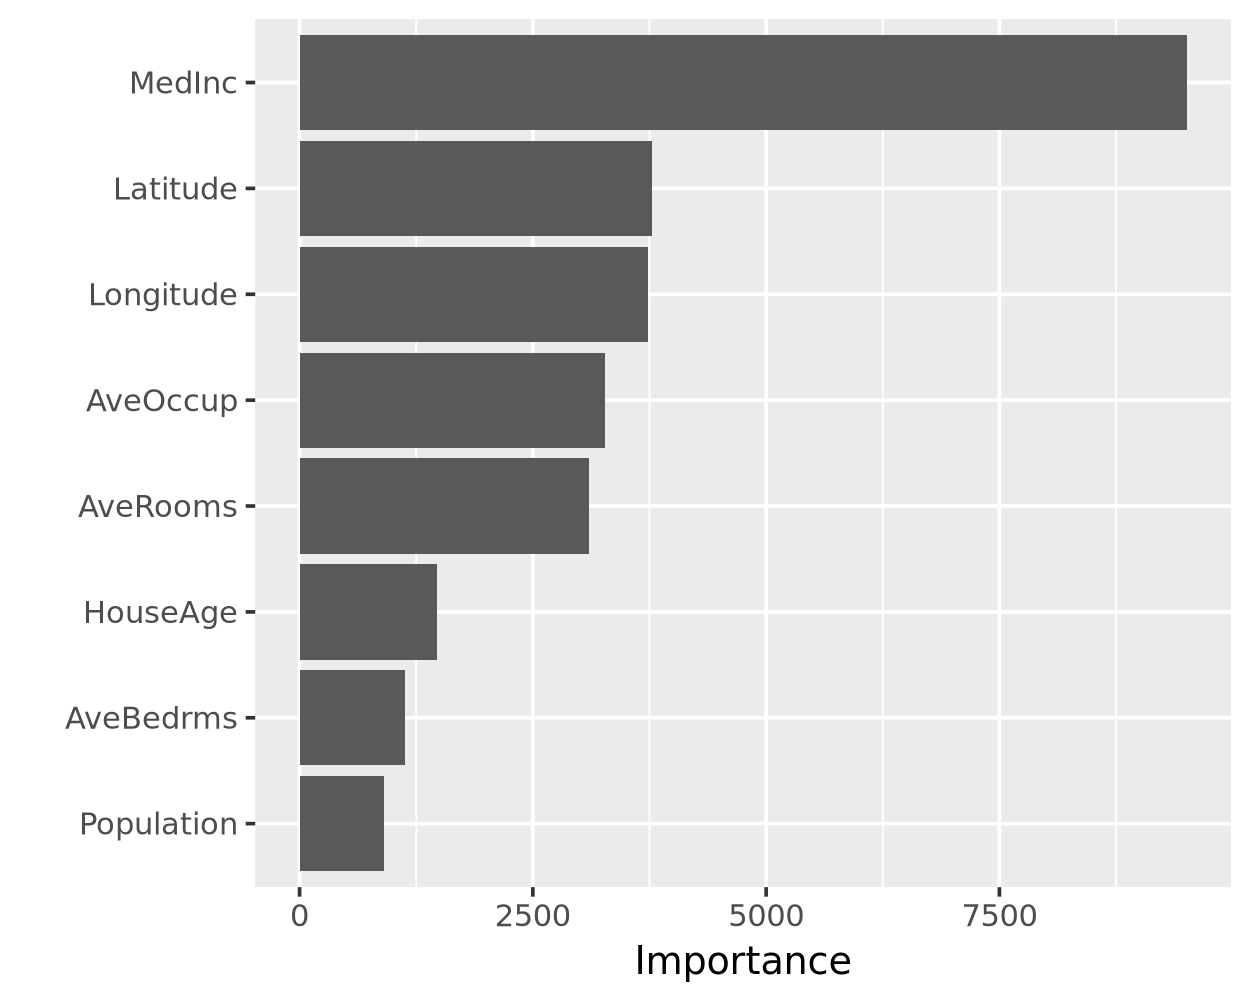

In [14]:
# Extract the fitted engine
rf_fit_engine <- extract_fit_engine(rf_fit)

# Plot feature importances using vip
vip(rf_fit_engine)



It looks like `Latitude` and `Longitude` are important for precicting home value. Let's explore those variables.

Install the `mapdata` package into your `data730` environment.

1. Open a Terminal, and,
2. Run the following command:

```bash
conda install -c conda-forge -n data730 r-mapdata
```

Load the `mapdata` package.

In [10]:
library(mapdata)

The following code will generate a map of California. Adapt this code to plot `Latitude` and `Longitude` from the `housing` dataset, color points by the `MedianHouseValue`. [Here is an example for reference](https://raw.githubusercontent.com/UNC-DATA-730/a10/main/example.png).


```r
california = map_data("state") |> filter(region == 'california')

ggplot(data = california) + 
    geom_polygon(aes(x = long, y = lat), fill = "grey90", color = "grey40") +
    coord_quickmap() +
    theme_void()
```

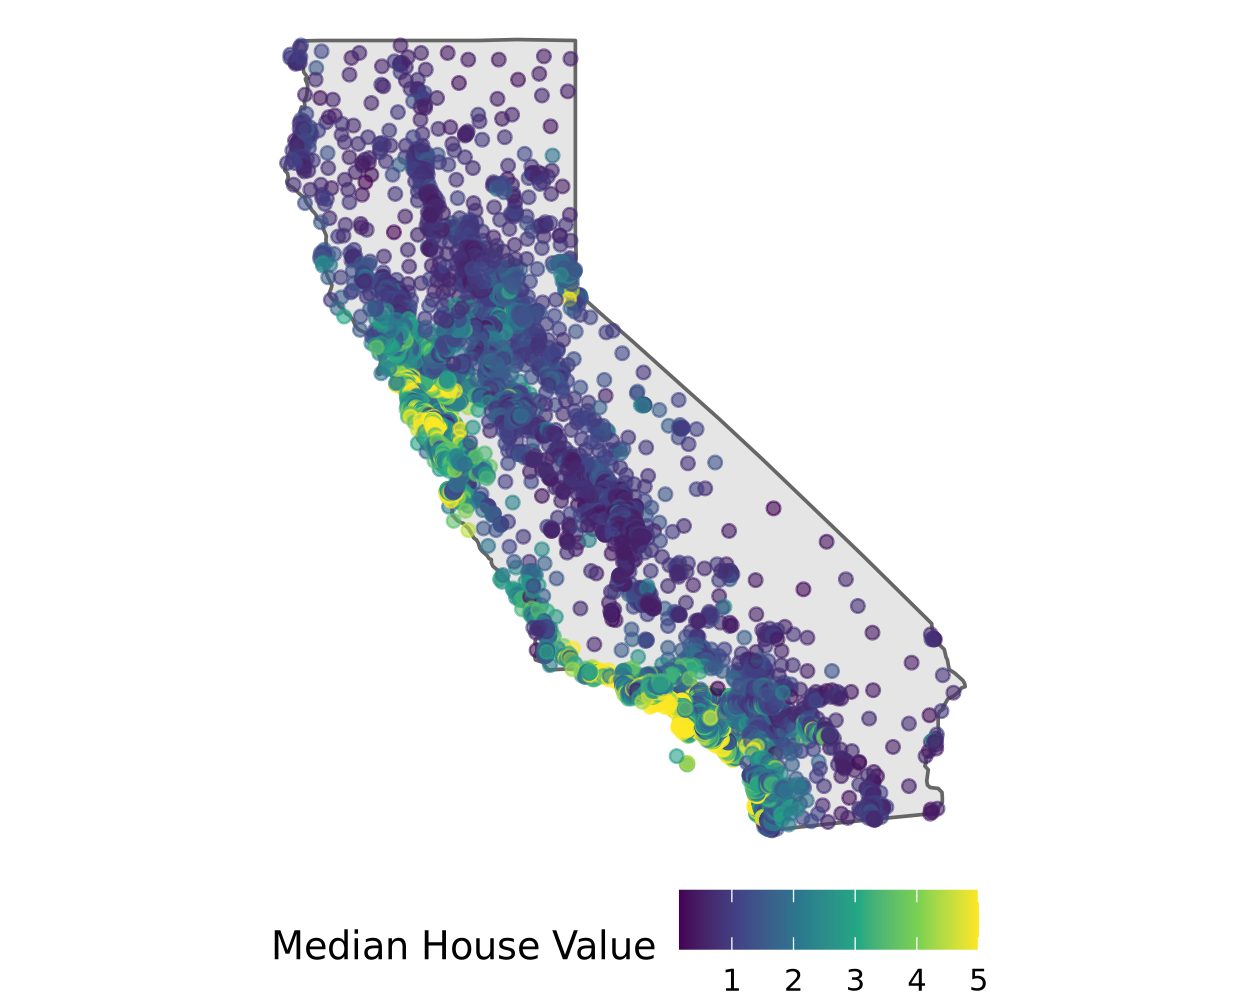

In [20]:

california <- map_data("state") %>% filter(region == 'california')

# Plot the map with housing data points
ggplot(data = california) + 
    geom_polygon(aes(x = long, y = lat), fill = "grey90", color = "grey40") +
    coord_quickmap() +
    geom_point(data = housing, 
               aes(x = Longitude, y = Latitude, color = MedianHouseValue), 
               alpha = 0.6, size = 1.5) +
    scale_color_viridis_c(option = "viridis") + # Optionally change the color scale
    theme_void() +
    labs(color = "Median House Value") +
    theme(legend.position = "bottom")